In [1]:
pip install pandas matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re, fnmatch
import pandas as pd
import requests
from statistics import mean
import csv
import numpy as np
import glob
import os
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import math
import json
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk_resources = ['stopwords', 'punkt', 'averaged_perceptron_tagger', 'wordnet']
for resource in nltk_resources:
    nltk.download(resource, quiet=True)

In [4]:
fake = pd.read_csv('/workspaces/fake_news_analysis/data/preprocessed/fake_preprocessed.csv', index_col=0)
real = pd.read_csv('/workspaces/fake_news_analysis/data/preprocessed/real_preprocessed.csv', index_col=0)

df = pd.concat([fake, real])

In [5]:
def string_to_list(text):
    try:
        return ast.literal_eval(text)
    except ValueError:
        return None

df['processed_text'] = df['processed_text'].apply(string_to_list)

In [6]:
dimensions = ['care', 'fairness', 'loyalty', 'authority', 'sanctity']
polarities = ['virtue', 'vice']

# dictionaries
dictionary_paths = {
    'mft': '/workspaces/fake_news_analysis/dictionaries/processed/mft_dictionary.json',
    'mfd2': '/workspaces/fake_news_analysis/dictionaries/processed/mfd2_dictionary.json',
    'mfd1': '/workspaces/fake_news_analysis/dictionaries/processed/mfd1_dictionary.json',
    'emfd': '/workspaces/fake_news_analysis/dictionaries/processed/emfd_dictionary.json',
    'ms': '/workspaces/fake_news_analysis/dictionaries/processed/ms_dictionary.json'
}


loaded_dictionaries = {}
for key, path in dictionary_paths.items():
    with open(path, 'r') as file:
        loaded_dictionaries[key] = json.load(file)

### Vectorization

In [7]:
# TF normalized

def score_tf(tokens, dictionary):
    # Initialize scores and term frequencies
    scores = {dimension: {polarity: 0 for polarity in dictionary[dimension]} for dimension in dictionary}
    tf = {token: tokens.count(token) for token in set(tokens)}
    tracked = {dimension: {polarity: [] for polarity in dictionary[dimension]} for dimension in dictionary}

    # Calculate maximum term frequency for normalization
    max_tf = max(tf.values()) if tf else 1

    # Iterate through each token and update scores based on normalized term frequency
    for token in set(tokens):  # Iterate through unique tokens for efficiency
        for dimension, polarities in dictionary.items():
            for polarity, words in polarities.items():
                if token in words:
                    # Calculate TF normalization factor
                    tf_factor = 0.5 + 0.5 * (tf[token] / max_tf)
                    # Update scores with TF normalization
                    scores[dimension][polarity] += tf_factor
                    if token not in tracked[dimension][polarity]:
                        tracked[dimension][polarity].append(token)

    vector = []
    for dimension in scores.keys():
        for polarity in scores[dimension].keys():
            vector.append(scores[dimension][polarity])

    return vector

In [8]:
keys = ['mft', 'mfd2', 'mfd1']

for key in keys:
    if key in loaded_dictionaries:
      df[key] = df['processed_text'].apply(lambda x: score_tf(x, loaded_dictionaries[key]))

In [9]:
def score_prob(tokens, dictionary):
    prob_sums = {dimension: {polarity: 0 for polarity in dictionary[dimension]} for dimension in dictionary}
    word_counts = {dimension: {polarity: 0 for polarity in dictionary[dimension]} for dimension in dictionary}
    tracked = {dimension: {polarity: [] for polarity in dictionary[dimension]} for dimension in dictionary}

    # Process tokens against the dictionary
    for token in tokens:
        for dimension, polarities in dictionary.items():
            for polarity, words_probs in polarities.items():
                if isinstance(words_probs, list) and words_probs:
                    for word_prob in words_probs:
                        if token == word_prob[0]:  # If the token matches the word
                            prob_sums[dimension][polarity] += word_prob[1]
                            word_counts[dimension][polarity] += 1
                            if token not in tracked[dimension][polarity]:
                                tracked[dimension][polarity].append(token)

    # Calculate averages based on tracked order
    avg_probs = {}
    for dimension in dictionary:  # Ensure dimension order matches 'tracked'
        avg_probs[dimension] = {}
        for polarity in dictionary[dimension]:  # Ensure polarity order matches 'tracked'
            if word_counts[dimension][polarity] > 0:
                avg = prob_sums[dimension][polarity] / word_counts[dimension][polarity]
            else:
                avg = 0
            avg_probs[dimension][polarity] = avg

    # Create the vector based on the same order as 'tracked'
    vector = []
    for dimension, polarities in tracked.items():  # Follow the order in 'tracked'
        for polarity in polarities:  # Follow the order in 'tracked'
            vector.append(avg_probs[dimension][polarity])

    # Ensure the vector is 10-dimensional
    vector = vector[:10] if len(vector) > 10 else vector + [0] * (10 - len(vector))

    return vector

In [10]:
df['emfd'] = df['processed_text'].apply(lambda x: score_prob(x, loaded_dictionaries['emfd']))

In [11]:
def score_range(tokens, dictionary):

    # Initialize scores and counts
    scores = {f'{dimension}_{polarity}': [] for dimension in dimensions for polarity in polarities}

    # Iterate through tokens and update scores
    for token in tokens:
        for dimension in dimensions:
            for polarity in polarities:
                key = f'{dimension}_{polarity}'
                if dimension in dictionary and polarity in dictionary[dimension]:
                    for word, score in dictionary[dimension][polarity]:
                        if token == word:
                            scores[key].append(score)

    # Compute averages for each dimension and polarity
    averages = []
    for key in scores:
        if scores[key]:
            avg_score = sum(scores[key]) / len(scores[key])
        else:
            avg_score = 0  # Default to 0 if no scores were found
        averages.append(avg_score)

    # Ensure the result is 10-dimensional
    return averages

In [12]:
df['ms'] = df['processed_text'].apply(lambda x: score_range(x, loaded_dictionaries['ms']))

### Word cloud

In [13]:
flattened_morality_words = {}
for category, subcats in loaded_dictionaries['mfd1'].items():
    for subcat, words in subcats.items():
        for word in words:
            flattened_morality_words[word] = category

def filter_morality_words(text, flattened_morality_words):
    filtered_text = [word.lower() for word in text if word.lower() in flattened_morality_words]
    return ' '.join(filtered_text)

df['filtered_text'] = df['processed_text'].apply(lambda x: filter_morality_words(x, flattened_morality_words))

fake = df[df['type'] == 'fake']
real = df[df['type'] == 'real']

fake_text = ' '.join(fake['filtered_text'])
real_text = ' '.join(real['filtered_text'])

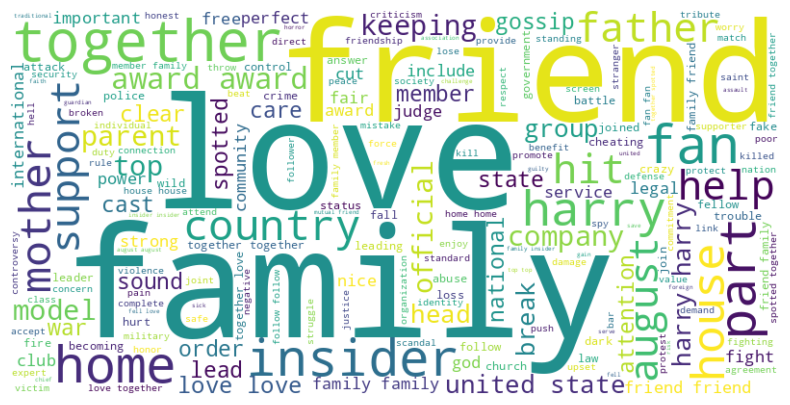

In [14]:
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

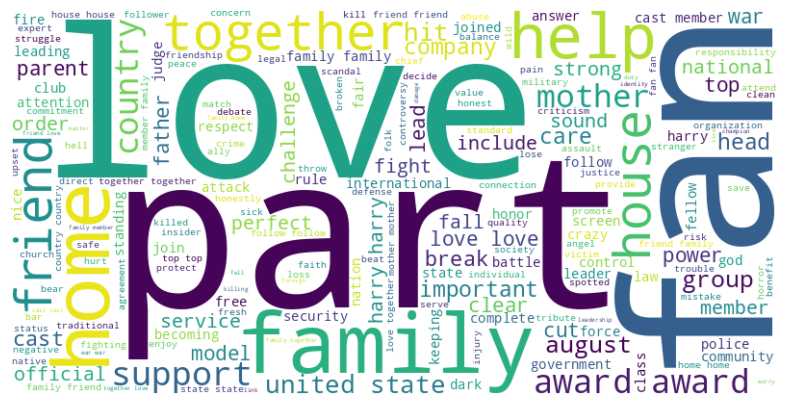

In [15]:
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Moral overlap rate

In [16]:
fake_moral_tokens = nltk.word_tokenize(fake_text)
fake_moral_tokens_unique = set(fake_moral_tokens)
real_moral_tokens = nltk.word_tokenize(real_text)
real_moral_tokens_unique = set(real_moral_tokens)

# Calculate overlap - intersaction of unique words
overlap = fake_moral_tokens_unique.intersection(real_moral_tokens_unique)
overlap_count = len(overlap)
print(overlap_count)

# Calculate total unique words
total_unique_words = fake_moral_tokens_unique.union(real_moral_tokens_unique)
total_unique_count = len(total_unique_words)

# Calculate overlap percentage
overlap_percentage = (overlap_count / total_unique_count) * 100
print(round(overlap_percentage,2))

1371
76.89


### Fake news vs Real: comparative analysis

In [17]:
vectors = ['mft', 'mfd2', 'mfd1', 'emfd', 'ms']

In [18]:
fake_means = {vec: [] for vec in vectors}

for vector in vectors:
    fake_means[vector] = [sum(pos) / len(pos) for pos in zip(*fake[vector])]

fake_means_df = pd.DataFrame(fake_means)
fake_means_df

,mft,mfd2,mfd1,emfd,ms
0,0.136009,1.266118,1.086183,0.116534,1.720058
1,0.220923,0.486153,1.278119,0.138829,0.688832
2,0.100425,0.396718,0.567236,0.103815,2.697817
3,0.011188,0.523589,0.080857,0.115797,0.104055
4,0.743045,1.571572,1.954154,0.113665,4.890202
5,0.039785,0.066906,0.365459,0.097695,0.225528
6,0.463507,1.176671,1.704051,0.094797,3.153644
7,0.045564,0.156777,0.252614,0.100757,0.325108
8,0.077198,0.642194,0.430914,0.097480,1.074124
9,0.050278,0.389471,0.477208,0.099729,0.260686


In [19]:
real_means = {vec: [] for vec in vectors}

for vector in vectors:
    real_means[vector] = [sum(pos) / len(pos) for pos in zip(*real[vector])]

real_means_df = pd.DataFrame(real_means)
real_means_df

,mft,mfd2,mfd1,emfd,ms
0,0.150413,1.377975,1.147989,0.117594,1.787448
1,0.247932,0.610727,1.441486,0.132176,0.668966
2,0.108006,0.415095,0.601594,0.103183,2.642789
3,0.014640,0.524249,0.105838,0.105861,0.088451
4,0.601918,1.519769,1.865809,0.113053,4.284452
5,0.042957,0.047939,0.397513,0.089358,0.237721
6,0.525785,1.344792,2.001239,0.094568,3.368685
7,0.037203,0.157072,0.280188,0.093387,0.273934
8,0.079906,0.613330,0.482671,0.097187,1.101246
9,0.057679,0.353340,0.458170,0.093872,0.273527


In [20]:
def test_normality_for_vector_column(df, column_name):
    # Determine the number of dimensions in your vectors
    num_dimensions = len(df[column_name].iloc[0])

    results = []
    for dim in range(num_dimensions):
        # Extract the specific dimension from each vector
        dimension_data = df[column_name].apply(lambda x: x[dim])

        # Perform Shapiro-Wilk test on this dimension
        test_stat, p_value = stats.shapiro(dimension_data)

        # Collect results
        results.append({
            'Dimension': dim,
            'Test Statistic': test_stat,
            'p-value': p_value < 0.05
        })

    return pd.DataFrame(results)

In [21]:
normality_test_results = {'fake': {}, 'real': {}}

for vec in vectors:
    normality_test_results['fake'][vec] = test_normality_for_vector_column(fake, vec)
    normality_test_results['real'][vec] = test_normality_for_vector_column(real, vec)

print(normality_test_results)

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13985.
  res = hypotest_fun_out(*samples, **kwds)


{'fake': {'mft':    Dimension  Test Statistic  p-value
0          0        0.480080     True
1          1        0.529911     True
2          2        0.414821     True
3          3        0.116018     True
4          4        0.875947     True
5          5        0.251525     True
6          6        0.626886     True
7          7        0.272111     True
8          8        0.370330     True
9          9        0.294162     True, 'mfd2':    Dimension  Test Statistic  p-value
0          0        0.784432     True
1          1        0.456331     True
2          2        0.607829     True
3          3        0.699349     True
4          4        0.815876     True
5          5        0.296068     True
6          6        0.639307     True
7          7        0.473727     True
8          8        0.618068     True
9          9        0.563558     True, 'mfd1':    Dimension  Test Statistic  p-value
0          0        0.701431     True
1          1        0.605208     True
2          2   

In [22]:
def mann_whitney_test_dim(df1, df2, col):
    num_dimensions = len(df1[col].iloc[0])

    results = []
    for dim in range(num_dimensions):
        # extract dimension
        data1 = df1[col].apply(lambda x: x[dim])
        data2 = df2[col].apply(lambda x: x[dim])

        # test
        stat, p = mannwhitneyu(data1, data2)

        # append to the results
        results.append({
            'Dimension': f"Dimension {dim+1}",
            'U-Statistic': stat,
            'p-value': p
        })

    return pd.DataFrame(results)

In [23]:
mw_test_results = real_means = {vec: [] for vec in vectors}

for vec in vectors:
    mw_test_results[vec] = mann_whitney_test_dim(fake, real, vec)

dimensions = [f"Dimension {i+1}" for i in range(len(mw_test_results['mft']))]
combined_results = pd.DataFrame(index=dimensions)

for vec, result_df in mw_test_results.items():
    combined_results[f"{vec}_U-Statistic"] = result_df['U-Statistic'].values
    combined_results[f"{vec}_p-value"] = result_df['p-value'].values

print(combined_results)

              mft_U-Statistic   mft_p-value  mfd2_U-Statistic  mfd2_p-value  \
Dimension 1        31869602.0  2.176319e-01        31480437.5  3.520830e-02   
Dimension 2        31937962.5  4.101513e-01        30928755.5  1.027427e-05   
Dimension 3        32065639.0  7.113385e-01        32120155.0  9.502805e-01   
Dimension 4        31999070.5  8.530724e-02        32632165.0  9.363488e-02   
Dimension 5        36509962.0  5.677733e-47        34217243.0  3.763426e-11   
Dimension 6        31959994.5  1.879076e-01        32846494.5  3.957925e-07   
Dimension 7        30841383.5  6.994897e-06        30507114.5  1.664962e-07   
Dimension 8        32615423.5  2.275898e-04        32394969.0  2.411926e-01   
Dimension 9        32121608.5  9.278995e-01        33486811.5  3.970637e-06   
Dimension 10       31806722.5  3.100569e-02        33387129.0  2.621381e-06   

              mfd1_U-Statistic  mfd1_p-value  emfd_U-Statistic  emfd_p-value  \
Dimension 1         32587365.0  1.475061e-01      

### Fake news vs Fake: comparative analysis in different fields (politics and entertainment)

In [24]:
politics = fake[fake['topic'] == 'politics']
entertainment = fake[fake['topic'] == 'entertainment']

In [25]:
politics_means = {vec: [] for vec in vectors}

for vector in vectors:
    politics_means[vector] = [sum(pos) / len(pos) for pos in zip(*politics[vector])]

politics_means_df = pd.DataFrame(politics_means)
politics_means_df

,mft,mfd2,mfd1,emfd,ms
0,0.140492,0.736977,0.964757,0.104128,2.191859
1,0.327823,0.701016,1.254290,0.150586,0.904068
2,0.097113,0.459872,0.561792,0.103703,2.453226
3,0.014524,0.507484,0.090280,0.125667,0.198542
4,0.414859,1.430550,1.856946,0.102724,3.885898
5,0.076687,0.035835,0.488430,0.102666,0.448870
6,0.602751,1.709538,2.075362,0.094200,4.086911
7,0.156963,0.217183,0.424642,0.108207,0.719858
8,0.075478,0.396919,0.337326,0.086274,1.248746
9,0.052785,0.330149,0.423426,0.103647,0.290801


In [26]:
entertainment_means = {vec: [] for vec in vectors}

for vector in vectors:
    entertainment_means[vector] = [sum(pos) / len(pos) for pos in zip(*entertainment[vector])]

entertainment_means_df = pd.DataFrame(entertainment_means)
entertainment_means_df

,mft,mfd2,mfd1,emfd,ms
0,0.135648,1.308793,1.095975,0.117534,1.682007
1,0.212301,0.468824,1.280040,0.137880,0.671473
2,0.100692,0.391625,0.567675,0.103825,2.717543
3,0.010918,0.524888,0.080097,0.115001,0.096434
4,0.769513,1.582945,1.961994,0.114548,4.971198
5,0.036809,0.069412,0.355541,0.097295,0.207515
6,0.452278,1.133696,1.674105,0.094845,3.078377
7,0.036579,0.151905,0.238740,0.100156,0.293272
8,0.077336,0.661975,0.438462,0.098383,1.060041
9,0.050076,0.394255,0.481546,0.099413,0.258258


In [27]:
normality_test_results_fakes = {'politics': {}, 'entertainment': {}}

for vec in vectors:
    normality_test_results_fakes['politics'][vec] = test_normality_for_vector_column(politics, vec)
    normality_test_results_fakes['entertainment'][vec] = test_normality_for_vector_column(entertainment, vec)

print(normality_test_results_fakes)

{'politics': {'mft':    Dimension  Test Statistic  p-value
0          0        0.502954     True
1          1        0.671637     True
2          2        0.429599     True
3          3        0.134177     True
4          4        0.722186     True
5          5        0.350913     True
6          6        0.761558     True
7          7        0.531667     True
8          8        0.372004     True
9          9        0.326366     True, 'mfd2':    Dimension  Test Statistic  p-value
0          0        0.752987     True
1          1        0.643468     True
2          2        0.721693     True
3          3        0.695096     True
4          4        0.895109     True
5          5        0.253413     True
6          6        0.880299     True
7          7        0.591704     True
8          8        0.619662     True
9          9        0.637688     True, 'mfd1':    Dimension  Test Statistic  p-value
0          0        0.769444     True
1          1        0.772800     True
2          

In [28]:
mw_test_results_fakes = real_means = {vec: [] for vec in vectors}

for vec in vectors:
    mw_test_results_fakes[vec] = mann_whitney_test_dim(politics, entertainment, vec)

dimensions = [f"Dimension {i+1}" for i in range(len(mw_test_results_fakes['mft']))]
combined_results_fakes = pd.DataFrame(index=dimensions)

for vec, result_df in mw_test_results_fakes.items():
    combined_results_fakes[f"{vec}_U-Statistic"] = result_df['U-Statistic'].values
    combined_results_fakes[f"{vec}_p-value"] = result_df['p-value'].values

print(combined_results_fakes)

              mft_U-Statistic   mft_p-value  mfd2_U-Statistic  mfd2_p-value  \
Dimension 1          735197.0  7.181767e-01          528217.0  8.305193e-18   
Dimension 2          819971.5  5.323584e-07          846179.5  7.678141e-09   
Dimension 3          731314.0  8.942345e-01          778902.5  1.782308e-02   
Dimension 4          732922.5  5.267048e-01          714317.5  4.979316e-01   
Dimension 5          504320.0  2.728635e-22          677630.5  2.827416e-02   
Dimension 6          767620.5  9.070512e-05          706983.0  5.174018e-02   
Dimension 7          825642.5  6.291867e-06          955387.5  3.077904e-22   
Dimension 8          845596.5  1.928915e-28          794427.5  9.211380e-05   
Dimension 9          727865.0  9.076146e-01          594897.5  1.507128e-09   
Dimension 10         737326.5  4.700157e-01          708619.5  3.089231e-01   

              mfd1_U-Statistic  mfd1_p-value  emfd_U-Statistic  emfd_p-value  \
Dimension 1           668393.5  8.933316e-03      

In [29]:
df.to_csv('/workspaces/fake_news_analysis/data/preprocessed/data_vectorized.csv')
combined_results.to_csv('/workspaces/fake_news_analysis/data/preprocessed/fake_real_results.csv')
combined_results_fakes.to_csv('/workspaces/fake_news_analysis/data/preprocessed/poli_ent_results.csv')